# Step 1: Scope the Project and Gather Data
Since the scope of the project will be highly dependent on the data, these two things happen simultaneously. In this step, you’ll:

Identify and gather the data you'll be using for your project (at least two sources and more than 1 million rows). See Project Resources for ideas of what data you can use.
Explain what end use cases you'd like to prepare the data for (e.g., analytics table, app back-end, source-of-truth database, etc.)

- Step 2: Explore and Assess the Data
Explore the data to identify data quality issues, like missing values, duplicate data, etc.
Document steps necessary to clean the data
- Step 3: Define the Data Model
Map out the conceptual data model and explain why you chose that model
List the steps necessary to pipeline the data into the chosen data model
- Step 4: Run ETL to Model the Data
Create the data pipelines and the data model
Include a data dictionary
Run data quality checks to ensure the pipeline ran as expected
Integrity constraints on the relational database (e.g., unique key, data type, etc.)
Unit tests for the scripts to ensure they are doing the right thing
Source/count checks to ensure completeness
- Step 5: Complete Project Write Up
What's the goal? What queries will you want to run? How would Spark or Airflow be incorporated? Why did you choose the model you chose?
Clearly state the rationale for the choice of tools and technologies for the project.
Document the steps of the process.
Propose how often the data should be updated and why.
Post your write-up and final data model in a GitHub repo.
Include a description of how you would approach the problem differently under the following scenarios:
If the data was increased by 100x.
If the pipelines were run on a daily basis by 7am.
If the database needed to be accessed by 100+ people.

# 1 Scope

The first data source for this projects is the Ginventory mobile application. The structure of the API has been reverse engineered with the help of an Android emulator and HTTP Toolkit, see more detailed description below. This will constitute our products data.

I will be generating purchases data with Faker, which is the second source I will be using.

# Reverse-engineering the API

The only place I was able to find the information I was looking for (some data on different gin brands) was stuck behind an iOS/Android app. The following is a high level description of how I accessed the data.
- The simplest way to approach the problem is to use an Android emulator, in this case I used Android Studio. Due to Android's strict Certificate Authority management it is a bit finicky to setup mitmproxy with a system certificate on an Android emulator. An alternative is using a rooted physical device, in which case you will have a much easier time with CA management.
- Download an APK version of your target app, and install it on the emulated device. 
- Install ADB, and make sure to add the platform-tools folder to your PATH variable. --> Guide Check if your emulator is connected to ADB with ADB devices.
- Install HTTP Toolkit. Select Android device via ADB as your traffic source and follow setup steps in the emulator.
- Done! You should be able to see HTTP requests coming in from the emulator.
- All there is left to do is find the GET request that you are after, find the URL structure and the API key which we will use to authenticate our requests.


One of the first requests the app sends returns the full list of gins/tonics on the site, with a reduced number of fields.

In [1]:
import pandas as pd
import numpy as np
import requests
import time
import json
import os
import boto3
from requests.exceptions import HTTPError
from botocore.exceptions import ClientError
import sql_statements
import redshift_connector

# Variables
baseURL = 'https://ginventory.reed.be/api/v2/products/{}?api_key={}&lang=en'
api_key = '175405344b34bde70ef2970b44e8f07d'
headers = {
    'User-Agent': 'Test, Peter Oravecz',
    'From': 'peteroravecz9@gmail.com'
}

raw_folder = "raw"
normalized_folder = "normalized_data"

s3_client = boto3.client("s3")
redshift = boto3.client('redshift')
iam = boto3.client('iam')
ec2 = boto3.resource("ec2")
redshift_data = boto3.client('redshift-data')

# Get requests

In [ ]:
# Get highest ID number from ginventory_short.json
# A version of the dataset is available from one of the first calls the app makes when establishing connection,
# with a reduced set of columns. The largest id num (8770) comes from this file (ginventory_short.json).
with open('raw/ginventory_short.json', 'r', encoding='utf-8') as file:
    file_json = json.load(file)

df = pd.DataFrame(file_json)
df['id'] = df['id'].apply(pd.to_numeric)
largest_id = df.sort_values('id', ascending=False).head(1)
largest_id = largest_id.iloc[0,0]
print(largest_id)

In [ ]:
# Looping through all the requests, save responses to local and S3
response_collection = []
for i in range(1,largest_id+1):
    url = baseURL.format(i, api_key)
    try:
        response = requests.get(url, headers = headers)
        response.raise_for_status()
        print(i)
        response_collection.append(response.json())
        time.sleep(0.1)
    except HTTPError as http_err:
        print(f'HTTP error occurred: {http_err}')
    except Exception as err:
        print(f'Other error occurred: {err}')
    else:
        print('Success!')
    
with open('/'.join([raw_folder, 'data_full.json']), 'w', encoding='utf-8') as f:
    json.dump(response_collection, f, ensure_ascii=False, indent=4)
print("Responses collected!")

# Upload raw file to s3
s3_client.upload_file('/'.join([raw_folder, 'data_full.json']), "ginventory-bucket", '/'.join([raw_folder, 'data_full.json']))

# Read in requests from file

In [2]:
# Read from local file
with open('/'.join([raw_folder, 'data_full.json']), 'r', encoding='utf-8') as file:
    file_json = json.load(file)

In [3]:
# Data cleaning
df = pd.json_normalize(file_json)
df = df.drop(['direct_purchase_url', 'user_rating', 'in_wishlist', 'in_cabinet', 'purchase_links.data',
              'perfect_tonics.data','perfect_garnishes.data', 'perfect_gins.data', 'description.content', 
              'description.google_translation', 'description.original_content'], axis=1)


# Correct abv values where format is ##/##, first number is taken
#df['abv'] = df[df["abv"].str.contains("/", na=False)].abv.str.split('/').str.get(0).str.strip()
df['abv'] = np.where(df["abv"].str.contains("/", na=False), df['abv'].str.split('/').str.get(0).str.strip(), df['abv'])

# Correct values with % in them, change commas to dots
df['abv'] = df['abv'].replace('%','', regex=True).replace(',','.', regex=True)

# Handling numeric columns to adhere to correct data types in downstream pipeline
df['abv'] = pd.to_numeric(arg=df['abv'] ,errors='coerce')
df['average_rating'] = df['average_rating'].apply(pd.to_numeric)

# Fill NA with 0, so we can downcast all values to integer
df['rating_count'] = df['rating_count'].fillna(0)
df['rating_count'] = pd.to_numeric(arg=df['rating_count'],downcast='integer')

# Correcting country column.
# Handling the case where country format = country / country (eg.: Switzerland / United States)
#df['country'] = df[df['country'].str.contains('/', na=False)].country.str.split('/').str.get(0).str.strip()
df['country'] = np.where(df['country'].str.contains('/', na=False), df['country'].str.split('/').str.get(0).str.strip(), df['country'])

# Country names that do not adhere to ISO country naming standards are replaced
country_corrections = {
    'Vietnam': 'Viet Nam',
    'Russia' : 'Russian Federation',
    'Taiwan' : 'Taiwan, Province of China',
    'U.S. Virgin Islands' : 'Virgin Islands, U.s.',
    'Hong Kong SAR China' : 'Hong Kong',
    'Unknown or Invalid Region' : None,
    '' : None,
    }

for i in country_corrections:
    df['country'] = np.where(df.country == i, country_corrections[i], df['country'])

df['country'] = np.where(df.producer == 'Little Brown Dog Spirits', 'United Kingdom', df['country'])

# We drop the remaining rows (5) without valid country values.
df = df[df.country.isna()==False]


df_gin = df[df.type == 'gin']
df_garnish = df[df.type == 'garnish']
df_garnish = df_garnish[['id', 'type', 'name']]
df_tonic = df[df.type == 'tonic']


In [4]:
# Save normalized tables to local and S3
os.makedirs(normalized_folder, exist_ok=True)
df_gin.to_csv('/'.join([normalized_folder, 'gins.csv']), sep=';', index=False)
df_garnish.to_csv('/'.join([normalized_folder, 'garnishes.csv']), sep=';', index=False)
df_tonic.to_csv('/'.join([normalized_folder, 'tonics.csv']), sep=';', index=False)

s3_client.upload_file('/'.join([normalized_folder, 'gins.csv']), "ginventory-bucket", '/'.join([normalized_folder, 'gins.csv']))
s3_client.upload_file('/'.join([normalized_folder, 'garnishes.csv']), "ginventory-bucket", '/'.join([normalized_folder, 'garnishes.csv']))
s3_client.upload_file('/'.join([normalized_folder, 'tonics.csv']), "ginventory-bucket", '/'.join([normalized_folder, 'tonics.csv']))


In [38]:
# Extract relationships between gins, garnishes and tonics
# These tables will form our many-to-many translation tables in our model

df = pd.DataFrame(file_json)
df = df[df.type == 'gin']

# Prepare dataframe with the gin->perfect tonic relationship
df["perfect_tonics"] = df["perfect_tonics"].str["data"]
df_perfect_tonics = df.explode("perfect_tonics")
df_perfect_tonics = pd.concat(
    [
        df_perfect_tonics,
        df_perfect_tonics.pop("perfect_tonics").apply(pd.Series).add_prefix("perfect_tonics_"),
    ], axis=1)

# Select the necessary columns, drop NA, change data types
df_perfect_tonics = df_perfect_tonics[['id', 'perfect_tonics_id']]
df_perfect_tonics.dropna(inplace = True)
df_perfect_tonics = df_perfect_tonics.astype(int)

# Save
df_perfect_tonics.to_csv('/'.join([normalized_folder, 'perfect_tonics.csv']), sep=';', index=False)
s3_client.upload_file('/'.join([normalized_folder, 'perfect_tonics.csv']), "ginventory-bucket", '/'.join([normalized_folder, 'perfect_tonics.csv']))

# Prepare dataframe with the gin->perfect garnish relationship
df["perfect_garnishes"] = df["perfect_garnishes"].str["data"]
df_perfect_garnishes = df.explode("perfect_garnishes")
df_perfect_garnishes = pd.concat(
    [
        df_perfect_garnishes,
        df_perfect_garnishes.pop("perfect_garnishes")
        .apply(pd.Series)
        .add_prefix("perfect_garnishes_"),
    ], axis=1)

# Select the necessary columns, drop NA, change data types
df_perfect_garnishes = df_perfect_garnishes[['id', 'perfect_garnishes_id']]
df_perfect_garnishes.dropna(inplace = True)
df_perfect_garnishes = df_perfect_garnishes.astype(int)

# Save
df_perfect_garnishes.to_csv('/'.join([normalized_folder, 'perfect_garnishes.csv']), sep=';', index=False)
s3_client.upload_file('/'.join([normalized_folder, 'perfect_garnishes.csv']), "ginventory-bucket", '/'.join([normalized_folder, 'perfect_garnishes.csv']))

## Exploring our main dataset


In [7]:
#  General counts in the dataset
print(f'Total number of gins in our dataset: {df_gin.id.count()}')
print(f'Total number of garnishes in our dataset: {df_garnish.id.count()}')
print(f'Total number of tonics in our dataset: {df_tonic.id.count()}')

print(f'{df_perfect_garnishes.nunique().id} Gins have at least one garnish indicated as a perfect match, {df_perfect_garnishes.perfect_garnishes_id.count()} perfect matches in total.')
print(f'{df_perfect_tonics.nunique().id} Gins have at least one tonic indicated as a perfect match, {df_perfect_tonics.perfect_tonics_id.count()} perfect matches in total.')


Total number of gins in our dataset: 7529
Total number of garnishes in our dataset: 229
Total number of tonics in our dataset: 676
4785 Gins have at least one garnish indicated as a perfect match, 9641 perfect matches in total.
4646 Gins have at least one tonic indicated as a perfect match, 7880 perfect matches in total.


In [67]:
# Best rated gins
df_gin_explore = df_gin[["name", "average_rating"]]
df_gin_explore.sort_values("average_rating", ascending=False).head(3)

,name,average_rating
1023,Gin Ceret,10.0
3266,Dancing Sands Dry Gin - (Also known as Sacred ...,9.9
2120,Spitzmund Gin Sherry Cask Reserve,9.9


array([[<AxesSubplot:title={'center':'average_rating'}>]], dtype=object)

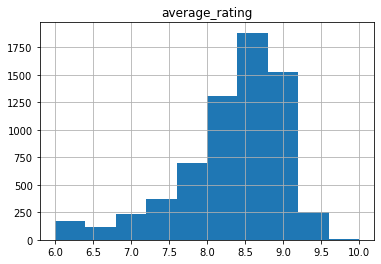

In [68]:
# Gin avergae rating histogram
df_gin.hist(column='average_rating' ,bins=10)

In [69]:
# Most rated gins 
df_gin_explore = df_gin[["name", "rating_count"]]
df_gin_explore.sort_values("rating_count", ascending=False).head(3)

,name,rating_count
1208,Hendrick's Gin,9151
1594,Monkey 47 Schwarzwald Dry Gin,7318
1040,Gin Mare,7022


array([[<AxesSubplot:title={'center':'rating_count'}>]], dtype=object)

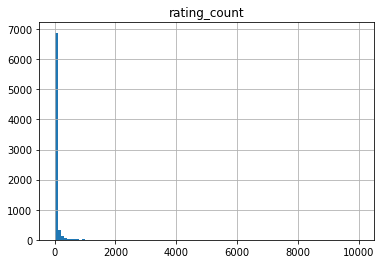

In [79]:
# Gin ratings count histogram
# Most gins
df_gin.hist(column='rating_count' ,bins=100, range=[0, 10000])

In [80]:
# Best rated producer
df_gin_explore = df_gin[["producer", "average_rating"]]
df_gin_explore.groupby('producer').mean().sort_values("average_rating",ascending=False).head(3)

,average_rating
producer,
Spitzmund,9.666667
Awardoo UG,9.500000
Norlyk Distillery ApS,9.475000


array([[<AxesSubplot:title={'center':'average_rating'}>]], dtype=object)

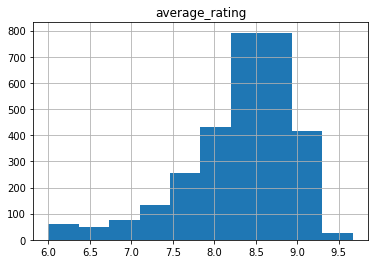

In [81]:
# Producer average ratings histogram
df_gin.groupby('producer').mean().hist(column='average_rating' ,bins=10)

# AWS

### IAM

In [5]:
# Create IAM role so we can access S3 from Redshift
try:
    print("1.1 Creating a new IAM Role") 
    dwhRole = iam.create_role(
        Path='/',
        RoleName='DWH_IAM_ROLE_NAME',
        Description = "Allows Redshift clusters to call AWS services on your behalf.",
        AssumeRolePolicyDocument=json.dumps(
            {'Statement': [{'Action': 'sts:AssumeRole',
               'Effect': 'Allow',
               'Principal': {'Service': 'redshift.amazonaws.com'}}],
             'Version': '2012-10-17'})
    )    
except Exception as e:
    print(e)

# Attach S3 access policy to our new role

iam.attach_role_policy(RoleName='DWH_IAM_ROLE_NAME',
                       PolicyArn="arn:aws:iam::aws:policy/AmazonS3ReadOnlyAccess"
                      )['ResponseMetadata']['HTTPStatusCode']

print("1.3 Get the IAM role ARN")
roleArn = iam.get_role(RoleName='DWH_IAM_ROLE_NAME')['Role']['Arn']

print(roleArn)

1.1 Creating a new IAM Role
An error occurred (EntityAlreadyExists) when calling the CreateRole operation: Role with name DWH_IAM_ROLE_NAME already exists.
1.3 Get the IAM role ARN
arn:aws:iam::752709659342:role/DWH_IAM_ROLE_NAME


### Redshift

In [8]:
# Create redshift cluster
try:
    response = redshift.create_cluster(
        ClusterType= 'single-node',
        NodeType='dc2.large',
        NumberOfNodes=1,

        #Identifiers & Credentials
        DBName='ginventory_auto',
        ClusterIdentifier='ginventoryDWH',
        MasterUsername='dwhuser',
        MasterUserPassword='Admin123456',
        
        #Roles (for s3 access)
        IamRoles=[roleArn]  
    )
except Exception as e:
    print(e)

In [6]:
# Prettify redshift cluster properties
def prettyRedshiftProps(props):
    keysToShow = ["ClusterIdentifier", "NodeType", "ClusterStatus", "MasterUsername", "DBName", "Endpoint", "NumberOfNodes", 'VpcId']
    x = [(k, v) for k,v in props.items() if k in keysToShow]
    return pd.DataFrame(data=x, columns=["Key", "Value"])

myClusterProps = redshift.describe_clusters(ClusterIdentifier='ginventoryDWH')['Clusters'][0]
prettyRedshiftProps(myClusterProps)

,Key,Value
0,ClusterIdentifier,ginventorydwh
1,NodeType,dc2.large
2,ClusterStatus,available
3,MasterUsername,dwhuser
4,DBName,ginventory_auto
5,Endpoint,{'Address': 'ginventorydwh.czo11jameqnn.eu-cen...
6,VpcId,vpc-01c2590b227c9dbaf
7,NumberOfNodes,1


In [ ]:
# Set a VPC security group rule to authorize ingress to the cluster's VPC Security Group
# Extract cluster info

vpc_security_group_id = myClusterProps["VpcSecurityGroups"][0]["VpcSecurityGroupId"]
try:
    # Extract security group for the VPC
    vpc_sg = ec2.SecurityGroup(id = vpc_security_group_id)
    
    # Authorize connection to the VPC
    vpc_sg.authorize_ingress(
        GroupName = vpc_sg.group_name,
        CidrIp = "0.0.0.0/0",
        IpProtocol = "TCP",
        FromPort = 5439,
        ToPort = 5439
    )
    print("Ingress to the VPC authorized")
    
except Exception as e:
    
    # Check if the error is a duplication error
    if "InvalidPermission.Duplicate" in str(e):
        print("Rule requested already exists")
    else:
        print(e)

In [7]:
# Drop and create all tables

for statement in sql_statements.drop_statements:
    response = redshift_data.execute_statement(
        ClusterIdentifier='ginventorydwh',
        Database='ginventory_auto',
        DbUser='dwhuser',
        Sql=statement
        )
 
for statement in sql_statements.create_statements:
    response = redshift_data.execute_statement(
        ClusterIdentifier='ginventorydwh',
        Database='ginventory_auto',
        DbUser='dwhuser',
        Sql=statement
        )

In [8]:
# Load tables from S3

file_names = ['garnishes', 'gins', 'perfect_garnishes', 'perfect_tonics', 'tonics']

for file_name in file_names:
    file_path = f"s3://ginventory-bucket/normalized_data/{file_name}.csv"

    sql_query = """
        COPY {}
        FROM '{}'
        IAM_ROLE '{}' 
        FORMAT AS csv
        IGNOREHEADER 1
        delimiter ';'
    """.format(file_name, file_path, roleArn)

    response = redshift_data.execute_statement(
        ClusterIdentifier='ginventorydwh',
        Database='ginventory_auto',
        DbUser='dwhuser',
        Sql=sql_query
    )

# Load countries data from SQL inserts
response = redshift_data.execute_statement(
    ClusterIdentifier='ginventorydwh',
    Database='ginventory_auto',
    DbUser='dwhuser',
    Sql=sql_statements.INSERT_INTO_COUNTRIES
    )

In [55]:


def redshift_get_statement_result_to_dataframe(response_id):
    '''
    Returns pandas dataframe of the statement Id passed from the response object 
    of the redshift-data.execute_statement method. If statement has no result set
    a message is returned.
    response = redshift_data.execute_statement(...)
    response_id = response['Id]
    '''
    while True:
        describe_obj = redshift_data.describe_statement(Id=response_id)
        status = describe_obj['Status']
        if status == 'ERROR' or status == 'FINISHED':
            if describe_obj['HasResultSet'] == True:
                statement_result = redshift_data.get_statement_result(Id=response_id)
                try:
                    df = pd.DataFrame(statement_result['Records'])
                    df.rename(columns=pd.DataFrame(statement_result['ColumnMetadata']).name, inplace=True)
                    df = df.apply(pd.Series)

                    for column in df.columns:
                        df[column] = df[column].apply(pd.Series)
                    return df
                except Exception as e:
                    print('Query status: ' + status)
                    print('Error: ' + statement_result['Error'])
            else:
                return 'Statement has no result set. Call with sql statement that produces a result set.'
            break
        else:
            time.sleep(1)



In [56]:
response = redshift_data.execute_statement(
    ClusterIdentifier='ginventorydwh',
    Database='ginventory_auto',
    DbUser='dwhuser',
    Sql='SELECT * FROM gins LIMIT 10;'
    )

redshift_get_statement_result_to_dataframe(response['Id'])

,id,type,name,first_name,second_name,picture_url,producer,country,abv,average_rating,rating_count
0,1,gin,1085 Toledo Gin,,,https://ginventory.reed.be/api/v2/products/1/p...,Licores Caro,Spain,40.0,6.6,74
1,6,gin,119 Gin,,,https://ginventory.reed.be/api/v2/products/6/p...,Carmelitano Distilleries,Spain,40.0,6.9,39
2,10,gin,12 Bridges Gin - (Discontinued),12 Bridges Gin,(Discontinued),https://ginventory.reed.be/api/v2/products/10/...,Integrity Spirits,United States,45.0,6.4,43
3,16,gin,12/11 Gin,,,https://ginventory.reed.be/api/v2/products/16/...,Destilerías Liber,Spain,42.5,6.9,23
4,22,gin,12/11 Gin Aurum Limited Edition,,,https://ginventory.reed.be/api/v2/products/22/...,Destilerías Liber,Spain,42.5,7.4,34
5,27,gin,1495 Gin Interpretatio,,,https://ginventory.reed.be/api/v2/products/27/...,Maison Villevert,France,45.0,7.5,5
6,28,gin,1495 Gin Verbatim,,,https://ginventory.reed.be/api/v2/products/28/...,Maison Villevert,France,45.0,7.3,8
7,29,gin,1528 Cocoa Gin,,,https://ginventory.reed.be/api/v2/products/29/...,Pico Cacao,Spain,40.0,7.6,80
8,37,gin,1827 Wild Swan Gin,,,https://ginventory.reed.be/api/v2/products/37/...,Wild Swan Distilling Co.,Australia,37.0,7.5,1
9,38,gin,1830 Sahara Fine London Style Dry Gin,,,https://ginventory.reed.be/api/v2/products/38/...,Highwood Distillers,Canada,40.0,6.3,3
